In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
%matplotlib inline

import os
import xarray as xr
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy
from numba import njit
import sectionate
from glob import glob
import momlevel
import doralite
from xhistogram.xarray import histogram
from cmip_basins.basins import generate_basin_codes
from functools import reduce
import warnings
warnings.filterwarnings('ignore')

In [3]:
def query_ondisk(path):
    cmd = ("dmls -l " + path) # cmd = ("dmls -l %s" %path)
    outputs = os.popen(cmd).read().split('\n')
    ondisk = {}
    for output in outputs[:-1]:
        if '(DUL)' in output:
            ondisk[output.split(' ')[-1]]=True
        else:
            ondisk[output.split(' ')[-1]]=False
    return ondisk
def issue_dmget(path):
    cmd = ("dmget " + path + " &")
    out = os.system(cmd)
    return out
def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

In [4]:
def MOC_basin_latrange_online(
    dir_vars,
    dir_grid,
    file_str_identifier,
    lat_range=[],
    lon_range=[],
    depth_range=[],
    basin_list=[],
    z_layer_var="rho2_l",
    z_inter_var="rho2_i",
    v_transport_var="vmo",
    time_limits=[],
    x_hpoint_1Dvar="xh",
    x_qpoint_1Dvar="xq",
    y_hpoint_1Dvar="yh",
    y_qpoint_1Dvar="yq",
    time_var="time",
    lons_tpoint="geolon",
    lats_tpoint="geolat",
    lons_cpoint="geolon_c",
    lats_cpoint="geolat_c",
    decode_times_flag=True,
    dmgetout=False,
    zarr_dir=''
):
    """Calculate MOC over the given range of latitudes (according to lat_range variable). 
    Defaults are set to calculate density-space AMOC from online density-space transports, 
    but the directory and variable names can be changed to select any e.g. offline variables. 
    
    Additional Args (see the MOC_xsec_nodes_online descriptions above):
        lat_range (list): 1-element, or 2-element vector (i.e. [start_lat,end_lat]). Can be left empty (i.e. global). Provide the latitudes, and not the grid indices. Must be in square brackets
        lon_range (list): 1-element, or 2-element vector (i.e. [start_lon,end_lon]). Can be left empty (i.e. global). Provide the longitudes, and not the grid indices. Must be in square brackets
        depth_range (list): 1-element, or 2-element vector (i.e. [start_depth,end_depth]).  Can be left empty. Provide the depths (or densities!), and not the indices. Must be in square brackets
        basin_list (list): list of basins according to John Krasting's generate_basin_codes, e.g. [2,3,5] is [Atl,Pac,Ind]. Others: 1=SO; 4=Arc; 6=Med; 7=Black Sea; 8=Hud Bay(?): 9=Balt. Sea(?); 10=Red Sea(?). 

    output:
        ds (xarray dataset):  dataset of meridional transport for the specific basin(s) (if any) and specified ranges
        grid (xarray dataset):  grid information 
        moc (xarray dataset): MOC streamfunction calculated for the specific basin(s) (if any) and specified ranges
        vmo_zonmean (xarray dataset): zonally-integrated meridional transports across the specific basin(s) (if any) and specified ranges

    Attribution: Matthew Thomas
    """
    
    ########################
    ### create a list of files to load:

    if len(file_str_identifier) > 1:
        vmo_vars_str = dir_vars + "*" + file_str_identifier[0] + "*." + v_transport_var + ".nc"
        files_timestep = glob(f"{vmo_vars_str}")
        for i in range(1,len(file_str_identifier)):
            vmo_vars_str=dir_vars+"*"+file_str_identifier[i]+"*."+v_transport_var+".nc"
            files_timestep = files_timestep + glob(f"{vmo_vars_str}")
        files_timestep = sorted(files_timestep)
        for i in range(len(files_timestep)):
            print(files_timestep[i])
    else:
        vmo_vars_str=dir_vars+"*"+file_str_identifier[0]+"*."+v_transport_var+".nc"
        files_timestep=glob(f"{vmo_vars_str}")
        # -- new -- 
        files_timestep = sorted(files_timestep)
        for i in range(len(files_timestep)):
            print(files_timestep[i])
        # --    
        if dmgetout: 
            print(f"{'dmget '+vmo_vars_str+' &'}")
            return [],[],[],[]

    ########################
    ### If a zarr_dir is given, modify the list of files to read to/write from there instead:

    if zarr_dir:
        for count, filename in enumerate(files_timestep):
            files_timestep[count] = zarr_dir+filename+'.zarr'
            if os.path.isdir(zarr_dir+filename+'.zarr')==False:
                ds_filename=xr.open_dataset(filename,decode_times=decode_times_flag, chunks={'xh' : 100, 'yh' : 100, 'yq' : 100})
                ds_filename.to_zarr(zarr_dir+filename+'.zarr')

    ########################
    ### Read the data from the list of files:

    ds = xr.open_mfdataset(files_timestep, decode_times=decode_times_flag)
    grid=xr.open_dataset(dir_grid)
    
    ### Cut off the final yq index, since the grid file has a problem there in CM4_hires
    ds = ds.isel( { y_qpoint_1Dvar: slice(0,-1) } )
    grid = grid.isel( { y_qpoint_1Dvar: slice(0,-1) } )
    
    #######################
    ### If the 1D coordinate names are not xh,xq, etc, then rename them to x_hpoint_1Dvar, x_qpoint_1Dvar etc (The sectionate tool requries it):

    if y_hpoint_1Dvar != "yh":
        ds = ds.rename({y_hpoint_1Dvar: 'yh'})
        grid = grid.rename({y_hpoint_1Dvar: 'yh'})
    if y_qpoint_1Dvar != "yq":
        ds = ds.rename({y_qpoint_1Dvar: 'yq'})
        grid = grid.rename({y_qpoint_1Dvar: 'yq'})
    if x_hpoint_1Dvar != "xh":
        ds = ds.rename({x_hpoint_1Dvar: 'xh'})
        grid = grid.rename({x_hpoint_1Dvar: 'xh'})
    if x_qpoint_1Dvar != "xq":
        ds = ds.rename({x_qpoint_1Dvar: 'xq'})
        grid = grid.rename({x_qpoint_1Dvar: 'xq'})
    if time_var != "time":
        ds = ds.rename({time_var: 'time'})
        grid = grid.rename({time_var: 'time'})    

    #######################
    ###bit of a dirty fix -- sometimes the grid and variable latitudes don't match (e.g. for the odiv209 _d2 grid):
    
    if ds['yq'].values[0]!=grid['yq'].values[0]: 
        grid['yq']=ds['yq'] 
    if ds['xh'].values[0]!=grid['xh'].values[0]: 
        grid['xh']=ds['xh']
        
    #######################
    ### Use John Krasting's generate_basin_codes script to create ocean masks:
    
    if basin_list:
        basincodes = generate_basin_codes(grid, lon="geolon", lat="geolat", mask="wet")
        basincodes_v = generate_basin_codes(grid, lon="geolon_v", lat="geolat_v", mask="wet_v")
        
        
    #######################
    ### Cut down the region to according to lat_range, lon_range and depth_range

    if len(lat_range)==2:
        ds=ds.sel(yq=slice(lat_range[0],lat_range[1]))
        grid=grid.sel(yq=slice(lat_range[0],lat_range[1]) , yh=slice(lat_range[0],lat_range[1]))
        grid=grid.sel(yq=slice(lat_range[0],lat_range[1]) , yh=slice(lat_range[0],lat_range[1]))
        if basin_list: 
            basincodes_v=basincodes_v.sel(yq=slice(lat_range[0],lat_range[1]))
            basincodes=basincodes.sel(yh=slice(lat_range[0],lat_range[1]))
    elif len(lat_range)==1:
        ds=ds.sel(yq=lat_range,method='nearest')
        grid=grid.sel(yq=lat_range,method='nearest')
        grid=grid.sel(yh=lat_range,method='nearest')
        if basin_list: 
            basincodes_v=basincodes_v.sel(yq=lat_range,method='nearest')
            basincodes=basincodes.sel(yh=lat_range,method='nearest')
    elif len(lat_range)>2:
        raise Exception("lat_range can have a length of zero (i.e. empty), or 1 or 2 elements")
    
    if len(lon_range)==2:
        ds=ds.sel(xh=slice(lon_range[0],lon_range[1]))
        grid=grid.sel(xh=slice(lon_range[0],lon_range[1]) , xq=slice(lat_range[0],lat_range[1]))
        if basin_list: 
            basincodes_v=basincodes_v.sel(xh=slice(lon_range[0],lon_range[1]))
            basincodes=basincodes.sel(xh=slice(lon_range[0],lon_range[1]))
    elif len(lon_range)==0: 'then do nothing'
    else:
        raise Exception("lon_range must be empty or have 2 elements")
        
    if len(depth_range)==2:
        ds=ds.sel(z_l=slice(depth_range[0],depth_range[1]))
    elif len(depth_range)==0: 'then do nothing'
    else:
        raise Exception("depth_range must either be empty or have 2 elements")
    
    ########################
    ### Use the basincodes to select only the ocean basins listed in basin_list:
    
    if len(basin_list)>0:
        conditions_ds = [basincodes_v==x for x in basin_list]
        conditions_grid = [basincodes==x for x in basin_list]
        combined_condition_ds=reduce(lambda x,y : x|y, conditions_ds)
        combined_condition_grid=reduce(lambda x,y : x|y, conditions_grid)
        ds=ds.where(combined_condition_ds).drop('lon')
        grid['deptho']=grid['deptho'].where(combined_condition_grid).drop('lon')
    
    ########################
    ### Calculate the AMOC etc for the region of choice
    
    vmo_zonmean=ds[v_transport_var].sum(x_hpoint_1Dvar)
    vmo_zonmean=vmo_zonmean/1030/1e6
    moc=vmo_zonmean.cumsum(z_layer_var) 

    
    
    return ds, grid, moc, vmo_zonmean

In [5]:
exps = ["odiv-2","odiv-231","odiv-255"] # CM4X

In [7]:
dmget_tog = 1
for i in range(len(exps)):
    experiment = doralite.dora_metadata(exps[i])
    print(exps[i])
    print(query_ondisk(experiment['pathPP'] + 'ocean_annual_z/ocean_annual_z.static.nc'))
    
    var1 = 'vmo'
    
    fl = sorted(glob(experiment['pathPP'] + 'ocean_annual_z/ts/annual/5yr/ocean_annual_z.*.' + var1 + '.nc'))
    fl2 = sorted(glob(experiment['pathPP'] + 'ocean_annual_rho2/ts/annual/5yr/ocean_annual_rho2.*.vmo.nc'))
    # fl2 = sorted(glob(experiment['pathPP'] + 'ocean_annual_z/ts/annual/5yr/ocean_annual_z.*.thetao.nc'))
    print(query_ondisk(fl[0])); print(query_ondisk(fl[-1]))
    print(query_ondisk(fl2[0])); print(query_ondisk(fl2[-1]))
    if dmget_tog > 0:
        if query_ondisk(fl[0])[fl[0]] & query_ondisk(fl[-1])[fl[-1]]:
            print('var1 good')
        else:
            issue_dmget(experiment['pathPP'] + 'ocean_annual_z/ts/annual/5yr/ocean_annual_z.*.' + var1 + '.nc')
        
        if (query_ondisk(fl2[0])[fl2[0]] == True) & (query_ondisk(fl2[-1])[fl2[-1]] == True):
            print('var2 good') 
        else:    
            # print('issue dmget: ' + experiment['pathPP'] + 'ocean_annual_z/ts/annual/5yr/ocean_annual_z.*.thetao.nc')
            # issue_dmget(experiment['pathPP'] + 'ocean_annual_z/ts/annual/5yr/ocean_annual_z.*.thetao.nc')
            issue_dmget(experiment['pathPP'] + 'ocean_annual_rho2/ts/annual/5yr/ocean_annual_rho2.*.vmo.nc')
            
        if query_ondisk(experiment['pathPP'] + 'ocean_annual_z/ocean_annual_z.static.nc')[experiment['pathPP'] + 'ocean_annual_z/ocean_annual_z.static.nc']:
            print('grid good')
        else:
            issue_dmget(experiment['pathPP'] + 'ocean_annual_z/ocean_annual_z.static.nc')

odiv-2
{'/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_historical/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc': True}
{'/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_historical/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/ocean_annual_z.1850-1854.vmo.nc': False}
{'/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_historical/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/ocean_annual_z.2010-2014.vmo.nc': False}
{'/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_historical/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_rho2/ts/annual/5yr/ocean_annual_rho2.1850-1854.vmo.nc': False}
{'/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_historical/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_rho2/ts/annual/5yr/ocean_annual_rho2.2010-2014.vmo.nc': False}
grid good
odiv-231
{'/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp

In [8]:
time_window = ["*.19[8-9]*", "*.200*"] # 1980-2009 for CM4X paper (make sure exps align with these dictionary entries)
run_dict = {
                'odiv2' :   {
                             'density_vars_path' : "/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_historical/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_rho2/ts/annual/5yr/",
                             'depth_vars_path' : "/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_historical/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/",
                             'grid_path' : "/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_historical/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc",
                             'file_str_identifier' : time_window,
                             'lat_range' : [-35,75], 
                             'basin_list': [2,4,6,9], 
                             'z_layer_var' : "z_l",'z_inter_var' : "z_i"
                             },    
                'odiv231' :   {
                             'density_vars_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_rho2/ts/annual/10yr/",
                             'depth_vars_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/",
                             'grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc",
                             'file_str_identifier' : time_window,
                             'lat_range' : [-35,75], 
                             'basin_list': [2,4,6,9], 
                             'z_layer_var' : "z_l", 'z_inter_var' : "z_i"
                             },
                'odiv255' :   {
                             'density_vars_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_annual_rho2/ts/annual/10yr/",
                             'depth_vars_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/",
                             'grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc",
                             'file_str_identifier' : time_window,
                             'lat_range' : [-35,75], 
                             'basin_list': [2,4,6,9], 
                             'z_layer_var' : "z_l", 'z_inter_var' : "z_i"
                             },
            }

In [12]:
%%time
ComputeDiag_dict_Online = {}
dmgetout_flag = False
zarr_dir='/work/jms/moc'
integrate_downwards_flag=False
if dmgetout_flag: print(f'run the following dmget commands:')
for keys in run_dict:
    ds_sig, grid_sig, moc_sig, vmo_sig_zonmean = MOC_basin_latrange_online(dir_vars=run_dict[keys]['density_vars_path'],dir_grid=run_dict[keys]['grid_path'],\
                                                                                     file_str_identifier=run_dict[keys]['file_str_identifier'],\
                                                                                     lat_range=run_dict[keys]['lat_range'],\
                                                                                     basin_list=run_dict[keys]['basin_list'],\
                                                                                     decode_times_flag=False,dmgetout=dmgetout_flag,zarr_dir=zarr_dir);
    ds_z, grid_z, moc_z, vmo_z_zonmean = MOC_basin_latrange_online(dir_vars=run_dict[keys]['depth_vars_path'],dir_grid=run_dict[keys]['grid_path'],\
                                                                             file_str_identifier=run_dict[keys]['file_str_identifier'],\
                                                                             lat_range=run_dict[keys]['lat_range'],\
                                                                             basin_list=run_dict[keys]['basin_list'],\
                                                                             z_layer_var=run_dict[keys]['z_layer_var'],\
                                                                             z_inter_var=run_dict[keys]['z_inter_var'],\
                                                                             decode_times_flag=False,dmgetout=dmgetout_flag,zarr_dir=zarr_dir);
    if len(ds_sig)>0:
        polarity_multiplier=1 if integrate_downwards_flag else -1
        AMOCsig_sf=ds_sig.vmo.mean('time').fillna(0).sum('xh').cumsum('rho2_l')/1e6/1030;
        AMOCz_sf=polarity_multiplier*(ds_z.vmo.mean('time').fillna(np.nan).sum('xh').sortby('z_l', ascending=integrate_downwards_flag).cumsum('z_l')/1e6/1030);
        # AMOCz_sf_0=ds_z.vmo.mean('time')
        # AMOCz_sf_0.where(~np.isnan(AMOCz_sf_0),other=np.nan)
        # AMOCz_sf=AMOCz_sf_0.sum('xh').cumsum('z_l')/1e6/1030;
        ComputeDiag_dict_Online[keys]={
                                'ds_z' : ds_z, 'grid_z' : grid_z , 'moc_z': moc_z, 'vmo_z_zonmean' : vmo_z_zonmean, 'AMOCsig_sf' : AMOCsig_sf,
                                'ds_sig' : ds_sig, 'grid_sig' : grid_sig , 'moc_sig': moc_sig, 'vmo_sig_zonmean' : vmo_sig_zonmean, 
                                'AMOCz_sf' : AMOCz_sf, "AMOCz_hov" : ds_z.vmo.fillna(np.nan)/1e6/1030 
                                };

/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_historical/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_rho2/ts/annual/5yr/ocean_annual_rho2.1980-1984.vmo.nc
/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_historical/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_rho2/ts/annual/5yr/ocean_annual_rho2.1985-1989.vmo.nc
/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_historical/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_rho2/ts/annual/5yr/ocean_annual_rho2.1990-1994.vmo.nc
/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_historical/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_rho2/ts/annual/5yr/ocean_annual_rho2.1995-1999.vmo.nc
/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_historical/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_rho2/ts/annual/5yr/ocean_annual_rho2.2000-2004.vmo.nc
/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_historical/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_rho2/ts/annual/5yr/ocean_annual_rho2.200

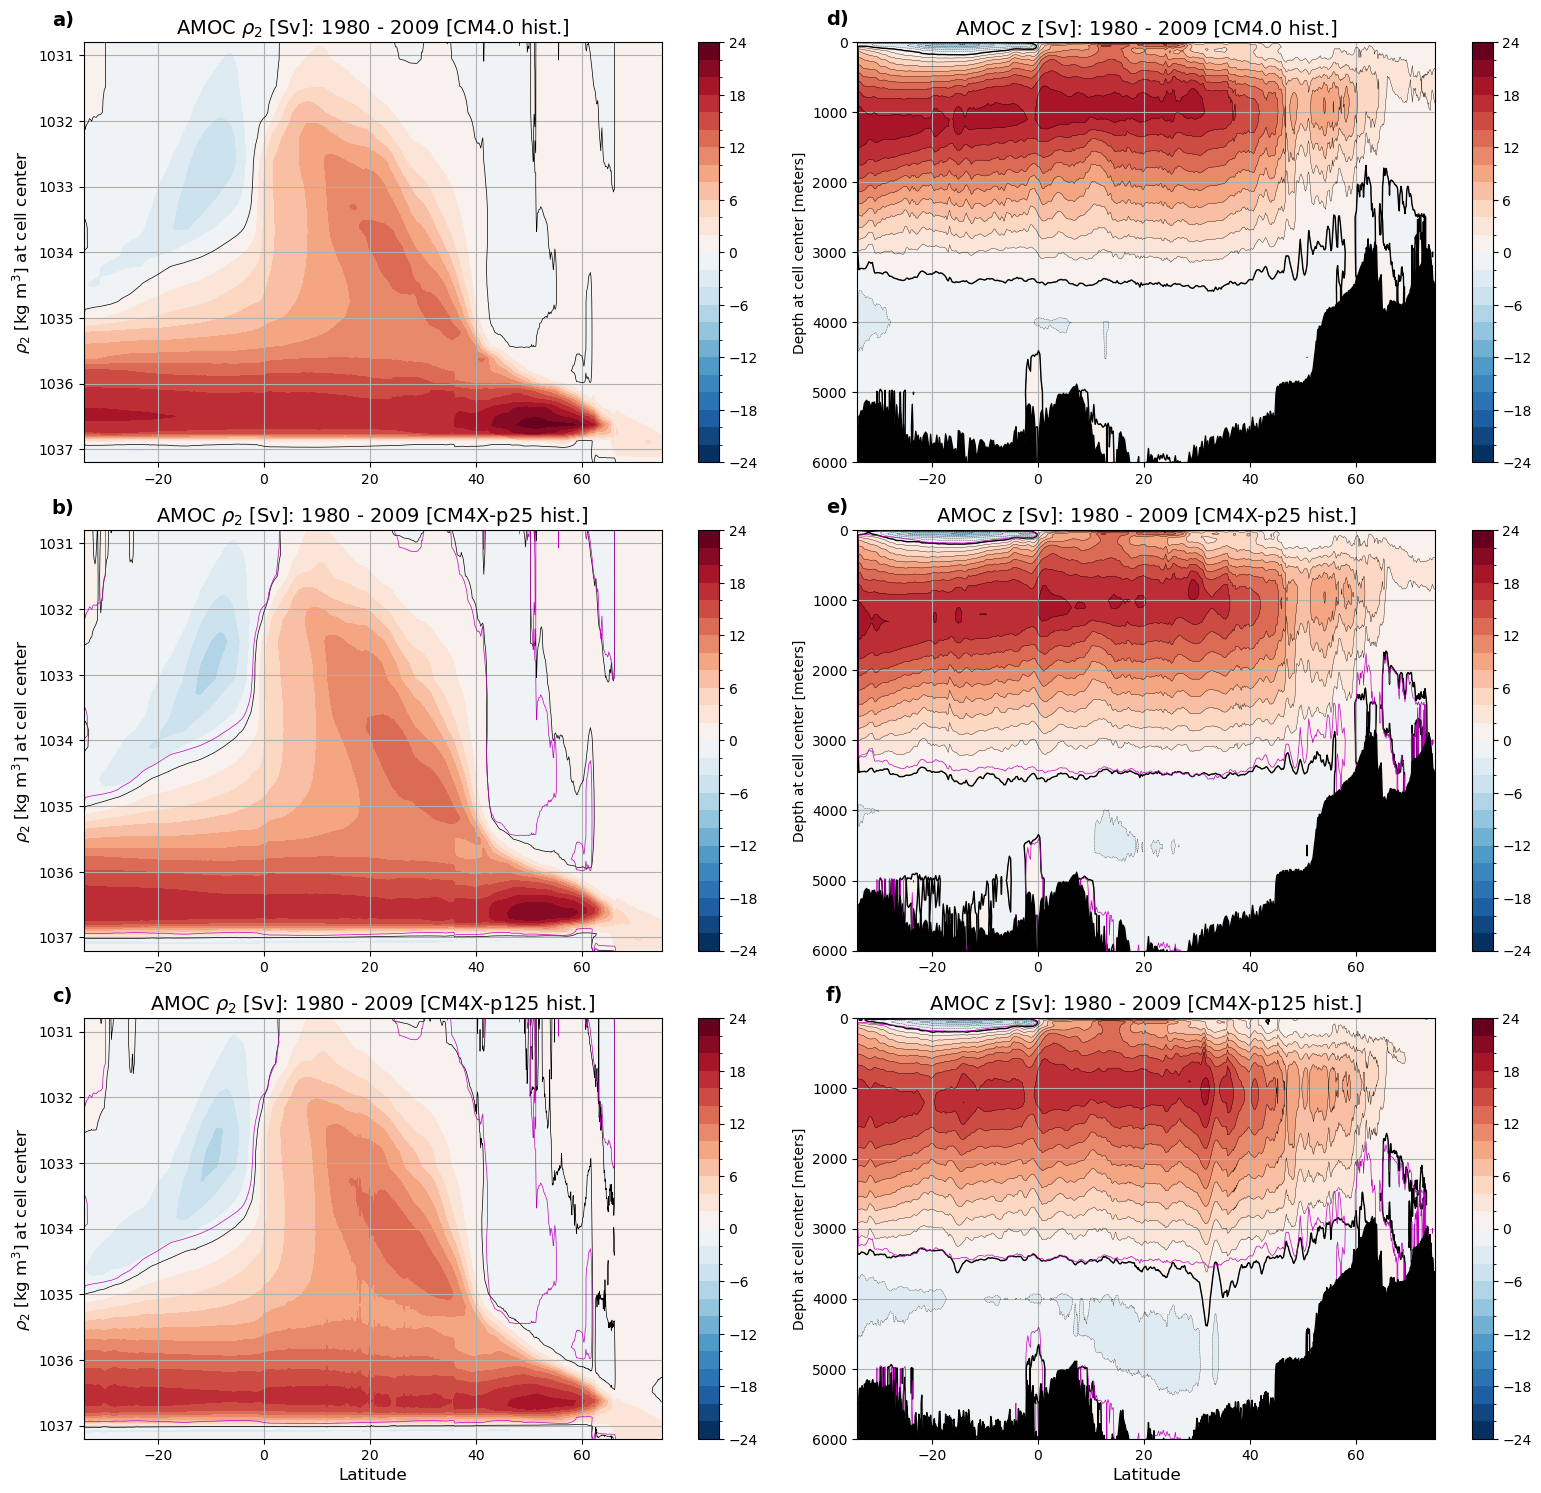

In [16]:
cm_names = ['CM4.0 hist.','CM4X-p25 hist.','CM4X-p125 hist.'];
load_data_flag=1
fig, ax = plt.subplots(len(ComputeDiag_dict_Online.keys()),2,figsize=(16,len(ComputeDiag_dict_Online.keys())*5))
count = 0 # subplot_num=1
for keys in run_dict:
    
    if load_data_flag:
        ComputeDiag_dict_Online[keys]['AMOCsig_sf']=ComputeDiag_dict_Online[keys]['AMOCsig_sf'].load()
        ComputeDiag_dict_Online[keys]['AMOCz_sf']=ComputeDiag_dict_Online[keys]['AMOCz_sf'].load()
        
    f_l = []
    for i in range(len(run_dict[keys]['file_str_identifier'])):
        f_l = f_l + glob(run_dict[keys]['density_vars_path'] + run_dict[keys]['file_str_identifier'][i] + '.vmo.nc')
    f_l = sorted(f_l)
    
    ComputeDiag_dict_Online[keys]['AMOCsig_sf'].plot.contourf(ax=ax[count,0],vmin=-24,vmax=24,levels=25,ylim=[1037.2,1030.8],cmap='RdBu_r',add_colorbar=True,add_labels=False)
    ComputeDiag_dict_Online[keys]['AMOCsig_sf'].plot.contour(ax=ax[count,0],levels=[0],colors='k',linewidths=0.5,ylim=[1037.2,1030.8],add_colorbar=False)
    ax[count,0].set_xlabel('')
    ax[count,0].set_xlim([-34,75])
    ax[count,0].set_ylabel(r'$\rho_2$ [kg m$^3$] at cell center',fontsize=12);
    ax[count,0].grid()
    ax[count,0].set_title(r'AMOC $\rho_2$ [Sv]: ' + f_l[0][-16:-12] + ' - ' + f_l[-1][-11:-7] + ' [' + cm_names[count] + ']', fontsize=14) #' [run = '+ keys + ']')
    
    ComputeDiag_dict_Online[keys]['AMOCz_sf'].plot.contourf(ax=ax[count,1],vmin=-24,vmax=24,levels=25,ylim=[6000,0],cmap='RdBu_r',add_colorbar=True,add_labels=False)
    ComputeDiag_dict_Online[keys]['AMOCz_sf'].plot.contour(ax=ax[count,1],levels=np.arange(-24,26,2),colors='k',ylim=[6000,0],linewidths=0.25,add_colorbar=False)
    ComputeDiag_dict_Online[keys]['AMOCz_sf'].plot.contour(ax=ax[count,1],levels=[0],colors='k',ylim=[6000,0],linewidths=1,add_colorbar=False)
    ax[count,1].fill_between(ComputeDiag_dict_Online[keys]['grid_z'].yh,ComputeDiag_dict_Online[keys]['grid_z'].deptho.where(ComputeDiag_dict_Online[keys]['grid_z'].deptho.xh>-80).max(dim='xh'),8000,color='k',zorder=3)
    ax[count,1].set_xlabel('')
    ax[count,1].set_xlim([-34,75])
    ax[count,1].grid()
    ax[count,1].set_title('AMOC z [Sv]: ' + f_l[0][-16:-12] + ' - ' + f_l[-1][-11:-7] + ' ['+ cm_names[count] + ']', fontsize=14)
    
    count = count + 1

ComputeDiag_dict_Online['odiv2']['AMOCsig_sf'].plot.contour(ax=ax[1,0],levels=[0],colors='m',linewidths=0.5,linestyle='--',ylim=[1037.2,1030.8],add_colorbar=False,add_labels=False,zorder=2)
ComputeDiag_dict_Online['odiv2']['AMOCsig_sf'].plot.contour(ax=ax[2,0],levels=[0],colors='m',linewidths=0.5,linestyle='--',ylim=[1037.2,1030.8],add_colorbar=False,add_labels=False,zorder=2)
ComputeDiag_dict_Online['odiv2']['AMOCz_sf'].plot.contour(ax=ax[1,1],levels=[0],colors='m',linewidths=0.5,linestyle='--',ylim=[6000,0],add_colorbar=False,add_labels=False,zorder=2)
ComputeDiag_dict_Online['odiv2']['AMOCz_sf'].plot.contour(ax=ax[2,1],levels=[0],colors='m',linewidths=0.5,linestyle='--',ylim=[6000,0],add_colorbar=False,add_labels=False,zorder=2) 
ax[0,0].text(-40,1030.55,'a)',fontsize=14,fontweight='bold'); ax[0,1].text(-40,-250,'d)',fontsize=14,fontweight='bold')
ax[1,0].text(-40,1030.55,'b)',fontsize=14,fontweight='bold'); ax[1,1].text(-40,-250,'e)',fontsize=14,fontweight='bold')
ax[2,0].text(-40,1030.55,'c)',fontsize=14,fontweight='bold'); ax[2,1].text(-40,-250,'f)',fontsize=14,fontweight='bold')
ax[count-1,0].set_xlabel('Latitude',fontsize=12); ax[count-1,1].set_xlabel('Latitude',fontsize=12); plt.tight_layout(); plt.show();
# fig.savefig('/home/jms/meetings/2025_04_30/AMOC_Y_Z_Sigma2.jpg', dpi=450)